In [1]:
% load_ext autoreload
% autoreload 2
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from helpers import set_size
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pickle
import cfrs


In [3]:
parameters = {
    "n_users": 600,
    "n_items": 600,
    "z": 60,
    "list_alphas": [1, 1, 1.3, 5, 16],
    "list_betas": [16, 5, 1.3, 1, 1],
    "list_scales": [0.8, 1.2, 1.5, 1.2, 0.8],
    "list_sizes": np.array([75, 125, 200, 125, 75]),
    "k": 10,
    "r": 20
}


0.026016260162596457
6.082458279763007e-32
600
0.008278145695359953
1.5177658665797652e-12
600
0.00038920809467911854
0.00038920809467911854
600
1.5177658665797652e-12
0.008278145695359953
600
6.082458279763007e-32
0.026016260162596457
600


{'L': (0, 40),
 'CL': (40, 166),
 'C': (166, 434),
 'CR': (434, 560),
 'R': (560, 600)}

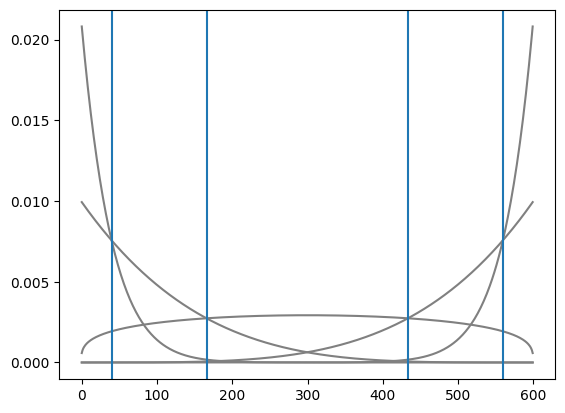

In [15]:
import scipy.stats as stats

rvs = []
for alpha, beta, scale in zip(parameters["list_alphas"],
                              parameters["list_betas"],
                              parameters["list_scales"]):
    x = np.arange(0, parameters["n_users"], 1)
    rv = stats.betabinom(parameters["n_users"] - 1, alpha, beta)
    print(rv.pmf(x)[0])
    print(rv.pmf(x)[-1])
    print(len(x))
    rvs.append(rv.pmf(x) * scale)
    plt.plot(x, rv.pmf(x) * scale, color="#808080")
tmp = np.argmax(np.stack(rvs), axis=0)
tmp = np.where(np.roll(tmp, 1) != tmp)[0][1:]

for i in tmp:
    plt.axvline(i)

orie_to_low_hi = {
    "L": (0, tmp[0]),
    "CL": (tmp[0], tmp[1]),
    "C": (tmp[1], tmp[2]),
    "CR": (tmp[2], tmp[3]),
    "R": (tmp[3], 600)
}
parameters["orie_to_low_hi"] = orie_to_low_hi
orie_to_low_hi


In [16]:
def prepare_matrices(parameters, seedv=97836):
    np.random.seed(seedv)

    S = cfrs.CollaborativeFiltering(
        n_users=parameters["n_users"],
        n_items=parameters["n_items"],
        k=parameters["k"],
        r=parameters["r"]
    )

    M = cfrs.Users(
        n_users=parameters["n_users"],
        n_items=parameters["n_items"],
        list_alphas=parameters["list_alphas"],
        list_betas=parameters["list_betas"],
        list_scales=parameters["list_scales"],
        list_sizes=parameters["list_sizes"],
    )

    cfrs.burn_in(M, S, z=parameters["z"])
    return S, M


S, M = prepare_matrices(parameters)

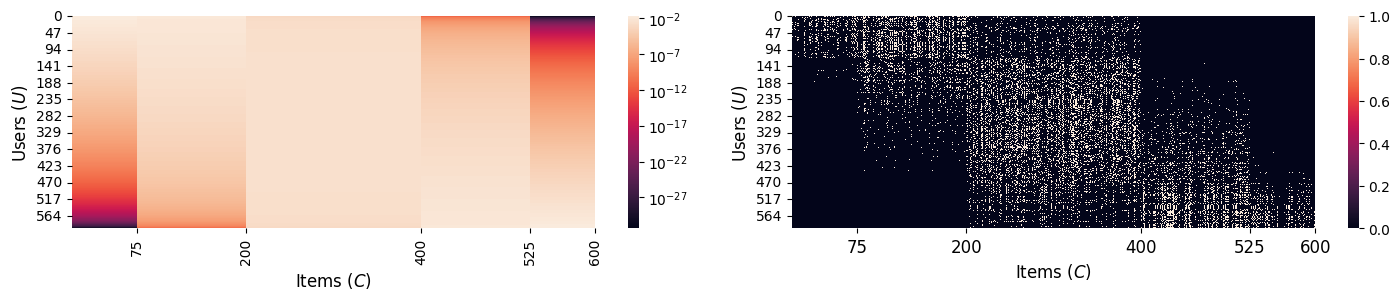

In [17]:

fig, axs = plt.subplots(1, 2, figsize=(9, 2.5), gridspec_kw={"wspace": 0.1}, sharex=True)

sns.heatmap(M.X, norm=LogNorm(), ax=axs[0])
axs[0].set_ylabel("Users ($U$)", fontsize=12)
axs[0].set_xlabel("Items ($C$)", fontsize=12)

sns.heatmap(S.X, ax=axs[1])
axs[1].set_ylabel("Users ($U$)", fontsize=12)

axs[1].set_xlabel("Items ($C$)", fontsize=12)
axs[1].set_xticks(parameters["list_sizes"].cumsum())
axs[1].set_xticklabels(parameters["list_sizes"].cumsum(), rotation=0, fontsize=12)
set_size(fig, (14, 3));

In [19]:
# Creates 10 randomly initialized matrices
vals = {}
vals["parameters"] = parameters
vals["num_matrices"] = 100
vals["matrices"] = {}
for i in tqdm(range(vals["num_matrices"])):
    S, M = prepare_matrices(parameters, seedv=i)
    vals["matrices"][i] = {"S": S, "M": M}

with open("mat2.pkl", "wb") as f:
    pickle.dump(vals, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:01<00:00, 27.61s/it]
